In [1]:
from rpy2.robjects.packages import importr
utils = importr("utils")
extremes = importr("extRemes")
ismev = importr("ismev")
eva = importr("eva")
gnFit = importr("gnFit")
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib.offsetbox import AnchoredText
from netCDF4 import num2date, date2num
statis = importr('stats')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import os
os.chdir(r"C:\Users\Pranjali\Downloads")

In [2]:
climate = xr.open_dataset("Climate.nc")
climate1 = climate.precipitation1

In [3]:
ppt5 = climate1.rolling(time=5).sum()


In [4]:
ppt = ppt5.where(ppt5>=0)
maxima5 = ppt.groupby('time.year').max('time')

C:\Users\Pranjali\Anaconda3\lib\site-packages\xarray\core\nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


In [5]:
lon1=[]
lat1=[]
rlv5=[]
paramlist5=[]
for i in range(129):
    for j in range(135):

        maxima51 = maxima5.sel(lat=climate.lat[i],lon=climate.lon[j])
        params5 = {}    
        if(maxima51.values[1]>0):
            #RL2 = []
            block_maxima=maxima51.values[~np.isnan(maxima51.values)]
            try:
                gev_fit =  eva.gevrFit(block_maxima)
            except:
                pass
            MLE_est = list(gev_fit.rx2('par.ests'))

            #print(block_maxima)


            params5['location'] = MLE_est[0]

            params5['scale'] =  MLE_est[1] 

            params5['shape'] = MLE_est[2]

            if MLE_est[1]<0:
                MLE_est[1] = 0.01

            y = eva.rgevr(10000, 1, loc = MLE_est[0], scale = MLE_est[1], shape = MLE_est[2])

            sig_test = statis.ks_test(block_maxima, y)

            params5['p_val'] = sig_test.rx2('p.value')[0]
            paramlist5.append(params5)

    #print(params)
  


            if params5['p_val']>0.05:

                temp = eva.gevrRl(gev_fit, 100, method = "delta")

                RL5 = temp.rx2('Estimate')[0]
#n['RLV2'][i][j] = RL2

            else:
                params5['p_val'] = np.nan
                params5['location'] = np.nan
                params5['scale'] = np.nan
                params5['shape'] = np.nan
            #print(RL2,climate.lat.values[i],climate.lon.values[j])
            rlv5.append(RL5)
            lat1.append(climate.lat.values[i])
            lon1.append(climate.lon.values[j])
#n['RLV2'][i][j] = np.nan
#print(RL2)
        else:
            params5['p_val'] = np.nan
            params5['location'] = np.nan
            params5['scale'] = np.nan
            params5['shape'] = np.nan
df5 = pd.DataFrame({'rlv5':rlv5,'lat1':lat1,'lon1':lon1})

C:\Users\Pranjali\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


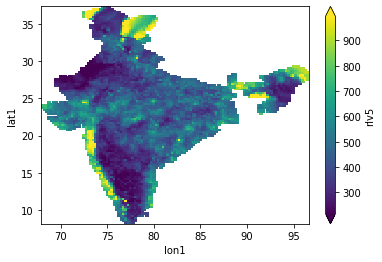

In [6]:
ds5= df5.set_index(['lat1','lon1']).to_xarray()
ds5['rlv5'].plot(robust=True)
plt.show()

In [7]:
ds5.to_netcdf(path=r'C:\Users\Pranjali\Downloads\ds5p.nc') 

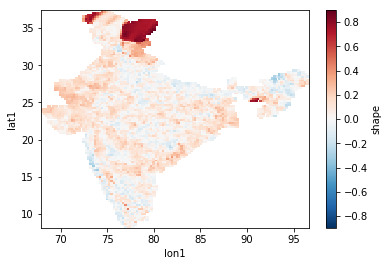

In [10]:
paramdict = {}
for k in set(k for p in paramlist5 for k in p):
    paramdict[k] = [p[k] for p in paramlist5 if k in p]
latlondict = {'lat1':lat1,'lon1':lon1}
paramdict.update(latlondict)
dp = pd.DataFrame.from_dict(paramdict) 
dsp5= dp.set_index(['lat1','lon1']).to_xarray()
dsp5['shape'].plot()
plt.show()